# 📏 Notebook 4: Evaluation & LDA Baseline

## 1. Setup

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pavannn16/BERTopic-arXiv-Analysis/blob/main/notebooks/04_evaluation.ipynb)

---

**Purpose:** Compute coherence, diversity, and compare with LDA baseline.

**Time:** ~5 minutes

In [29]:
# Install required packages
%pip install bertopic gensim scikit-learn pandas numpy plotly -q

In [30]:
# ============================================================
# PROJECT PATH SETUP - Works on Colab Web, VS Code, or Local
# ============================================================

import os
from pathlib import Path

# Detect environment and set project path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_PATH = '/content/drive/MyDrive/BERTopic-arXiv-Analysis'
    print("✅ Running on Google Colab")
else:
    PROJECT_PATH = str(Path(os.getcwd()).parent) if 'notebooks' in os.getcwd() else os.getcwd()
    print("✅ Running locally")

print(f"📁 Project path: {PROJECT_PATH}")

Project path: /content
Path exists: True


In [31]:
# Import libraries
import pandas as pd
import numpy as np
import json
from collections import Counter

# BERTopic
from bertopic import BERTopic

# Evaluation
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.metrics import silhouette_score

# LDA baseline
from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

print("Libraries imported!")

Libraries imported!


## 2. Load Model and Data

In [32]:
# Load BERTopic model
model_path = f"{PROJECT_PATH}/models/bertopic_model"
topic_model = BERTopic.load(model_path)
print("BERTopic model loaded!")

# Load data
df = pd.read_csv(f"{PROJECT_PATH}/data/processed/arxiv_cs_ai_processed.csv")
documents = df['text'].tolist()
print(f"Loaded {len(documents)} documents")

# Load embeddings
embeddings = np.load(f"{PROJECT_PATH}/data/embeddings/embeddings.npy")
print(f"Embeddings shape: {embeddings.shape}")

# Load topic assignments
results_df = pd.read_csv(f"{PROJECT_PATH}/results/topic_assignments.csv")
topics = results_df['topic'].tolist()
print(f"Topics loaded: {len(set(topics)) - 1} topics (excluding outliers)")

2025-12-02 03:35:29,380 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.


BERTopic model loaded!
Loaded 19898 documents
Embeddings shape: (19898, 768)
Topics loaded: 159 topics (excluding outliers)


## 3. Topic Diversity

In [33]:
def compute_topic_diversity(topic_model, top_n=10):
    """
    Compute topic diversity: proportion of unique words among top words.
    Higher diversity = topics are more distinct.
    """
    topics_dict = topic_model.get_topics()
    
    # Exclude outlier topic
    if -1 in topics_dict:
        del topics_dict[-1]
    
    all_words = []
    for topic_id, words in topics_dict.items():
        topic_words = [word for word, _ in words[:top_n]]
        all_words.extend(topic_words)
    
    unique_words = set(all_words)
    diversity = len(unique_words) / len(all_words) if all_words else 0
    
    return diversity, len(unique_words), len(all_words)

# Compute diversity
diversity, n_unique, n_total = compute_topic_diversity(topic_model, top_n=10)

print("Topic Diversity Analysis")
print("=" * 40)
print(f"Unique words: {n_unique}")
print(f"Total words: {n_total}")
print(f"Diversity score: {diversity:.4f}")
print(f"\nInterpretation: {diversity*100:.1f}% of top words are unique across topics")

Topic Diversity Analysis
Unique words: 1098
Total words: 1590
Diversity score: 0.6906

Interpretation: 69.1% of top words are unique across topics


## 4. Topic Coherence (NPMI)

In [34]:
def compute_coherence(topic_model, documents, coherence_type='c_npmi', top_n=10):
    """
    Compute topic coherence using gensim.
    
    Coherence types:
    - 'c_npmi': Normalized PMI (recommended)
    - 'c_v': Combination of indirect confirmation and cosine similarity
    - 'u_mass': UMass coherence
    """
    # Get topic words
    topics_dict = topic_model.get_topics()
    
    # Exclude outlier topic
    if -1 in topics_dict:
        del topics_dict[-1]
    
    # Extract top words for each topic
    topic_words = []
    for topic_id in sorted(topics_dict.keys()):
        words = [word for word, _ in topics_dict[topic_id][:top_n]]
        topic_words.append(words)
    
    # Tokenize documents
    tokenized_docs = [doc.lower().split() for doc in documents]
    
    # Create dictionary
    dictionary = Dictionary(tokenized_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.95)
    
    # Compute coherence
    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence=coherence_type
    )
    
    overall = coherence_model.get_coherence()
    per_topic = coherence_model.get_coherence_per_topic()
    
    return overall, per_topic, topic_words

# Compute NPMI coherence
print("Computing topic coherence (NPMI)...")
print("This may take a minute...\n")

coherence_npmi, per_topic_npmi, topic_words = compute_coherence(
    topic_model, documents, coherence_type='c_npmi', top_n=10
)

print("Topic Coherence Analysis (NPMI)")
print("=" * 40)
print(f"Overall coherence: {coherence_npmi:.4f}")
print(f"\nInterpretation:")
print(f"  NPMI ranges from -1 to 1")
print(f"  Higher values indicate more coherent topics")
print(f"  Typical good values: 0.05 to 0.20")

Computing topic coherence (NPMI)...
This may take a minute...

Topic Coherence Analysis (NPMI)
Overall coherence: 0.0717

Interpretation:
  NPMI ranges from -1 to 1
  Higher values indicate more coherent topics
  Typical good values: 0.05 to 0.20


In [35]:
# Per-topic coherence
topic_info = topic_model.get_topic_info()
topic_ids = [t for t in topic_info['Topic'].tolist() if t != -1]

coherence_df = pd.DataFrame({
    'Topic': topic_ids[:len(per_topic_npmi)],
    'Coherence_NPMI': per_topic_npmi,
    'Top_Words': [', '.join(words[:5]) for words in topic_words]
})

# Sort by coherence
coherence_df = coherence_df.sort_values('Coherence_NPMI', ascending=False)

print("\nTop 10 Most Coherent Topics:")
print(coherence_df.head(10).to_string(index=False))

print("\nBottom 5 Least Coherent Topics:")
print(coherence_df.tail(5).to_string(index=False))


Top 10 Most Coherent Topics:
 Topic  Coherence_NPMI                                                     Top_Words
    82        0.289120               theorem, lean, formal, proving, theorem proving
    64        0.271961           spiking, snns, neuromorphic, spiking neural, neural
    90        0.256954                   kv, cache, kv cache, attention, compression
    51        0.241645            federated, federated learning, fl, clients, client
    20        0.238003                  financial, market, trading, stock, portfolio
    55        0.223458              eeg, eeg signals, decoding, braincomputer, brain
    58        0.220069                   lora, lowrank, finetuning, peft, adaptation
    92        0.218035 anomaly, anomaly detection, anomalies, time series, detection
    25        0.195543      quantum, classical, circuits, quantum computing, circuit
    63        0.193460                      sql, texttosql, database, query, queries

Bottom 5 Least Coherent Topics:
 T

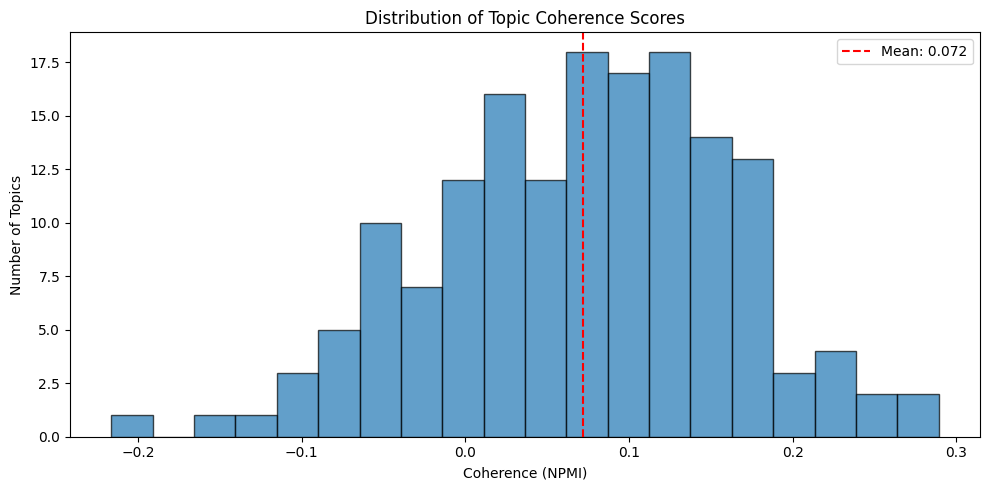

In [36]:
# Visualize coherence distribution
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(per_topic_npmi, bins=20, edgecolor='black', alpha=0.7)
ax.axvline(coherence_npmi, color='red', linestyle='--', label=f'Mean: {coherence_npmi:.3f}')
ax.set_xlabel('Coherence (NPMI)')
ax.set_ylabel('Number of Topics')
ax.set_title('Distribution of Topic Coherence Scores')
ax.legend()

plt.tight_layout()
plt.savefig(f"{PROJECT_PATH}/results/coherence_distribution.png", dpi=150)
plt.show()

## 5. Silhouette Score (Clustering Quality)

In [37]:
def compute_silhouette(embeddings, topics):
    """
    Compute silhouette score for clustering quality.
    Excludes outliers (-1) from computation.
    """
    # Remove outliers
    mask = np.array(topics) != -1
    filtered_embeddings = embeddings[mask]
    filtered_topics = np.array(topics)[mask]
    
    if len(set(filtered_topics)) < 2:
        return 0.0
    
    return silhouette_score(filtered_embeddings, filtered_topics)

# Compute silhouette
silhouette = compute_silhouette(embeddings, topics)

print("Clustering Quality (Silhouette Score)")
print("=" * 40)
print(f"Silhouette score: {silhouette:.4f}")
print(f"\nInterpretation:")
print(f"  Range: -1 to 1")
print(f"  >0.5: Strong cluster structure")
print(f"  0.25-0.5: Reasonable structure")
print(f"  <0.25: Weak structure or overlapping clusters")

Clustering Quality (Silhouette Score)
Silhouette score: 0.0396

Interpretation:
  Range: -1 to 1
  >0.5: Strong cluster structure
  0.25-0.5: Reasonable structure
  <0.25: Weak structure or overlapping clusters


## 6. Topic Size Analysis

In [38]:
# Topic sizes
topic_sizes = Counter(topics)
n_outliers = topic_sizes.get(-1, 0)
outlier_pct = 100 * n_outliers / len(topics)

# Remove outliers for analysis
if -1 in topic_sizes:
    del topic_sizes[-1]

sizes = list(topic_sizes.values())

print("Topic Size Analysis")
print("=" * 40)
print(f"Number of topics: {len(topic_sizes)}")
print(f"Total documents in topics: {sum(sizes)}")
print(f"Outliers: {n_outliers} ({outlier_pct:.1f}%)")
print(f"\nTopic size statistics:")
print(f"  Mean: {np.mean(sizes):.1f}")
print(f"  Median: {np.median(sizes):.1f}")
print(f"  Min: {np.min(sizes)}")
print(f"  Max: {np.max(sizes)}")
print(f"  Std: {np.std(sizes):.1f}")

Topic Size Analysis
Number of topics: 159
Total documents in topics: 14752
Outliers: 5146 (25.9%)

Topic size statistics:
  Mean: 92.8
  Median: 59.0
  Min: 20
  Max: 796
  Std: 110.5


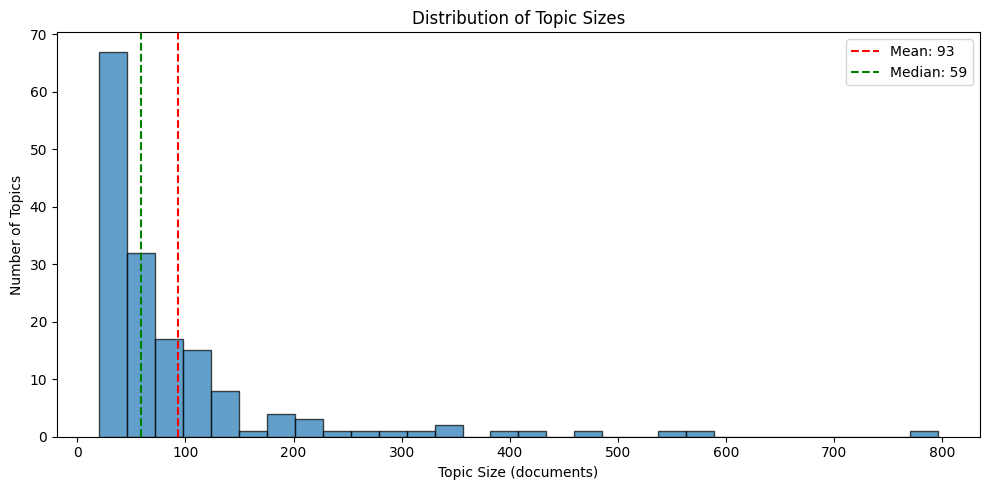

In [39]:
# Visualize topic size distribution
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(sizes, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(np.mean(sizes), color='red', linestyle='--', label=f'Mean: {np.mean(sizes):.0f}')
ax.axvline(np.median(sizes), color='green', linestyle='--', label=f'Median: {np.median(sizes):.0f}')
ax.set_xlabel('Topic Size (documents)')
ax.set_ylabel('Number of Topics')
ax.set_title('Distribution of Topic Sizes')
ax.legend()

plt.tight_layout()
plt.savefig(f"{PROJECT_PATH}/results/topic_size_distribution.png", dpi=150)
plt.show()

## 7. LDA Baseline Comparison

In [40]:
# Prepare data for LDA
print("Preparing LDA baseline...")

# Tokenize
tokenized_docs = [doc.lower().split() for doc in documents]

# Create dictionary and corpus
dictionary = Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=5, no_above=0.95)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

print(f"Dictionary size: {len(dictionary)}")
print(f"Corpus size: {len(corpus)}")

Preparing LDA baseline...
Dictionary size: 23936
Corpus size: 19898


In [41]:
# Train LDA with same number of topics as BERTopic
n_topics_bertopic = len(topic_model.get_topic_info()) - 1  # Exclude -1

print(f"Training LDA with {n_topics_bertopic} topics...")
print("This may take a few minutes...\n")

lda_model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=n_topics_bertopic,
    random_state=42,
    passes=10,
    workers=2
)

print("LDA training complete!")

Training LDA with 159 topics...
This may take a few minutes...

LDA training complete!


In [42]:
# Compute LDA coherence
lda_coherence_model = CoherenceModel(
    model=lda_model,
    texts=tokenized_docs,
    dictionary=dictionary,
    coherence='c_npmi'
)

lda_coherence = lda_coherence_model.get_coherence()

print(f"LDA Coherence (NPMI): {lda_coherence:.4f}")

LDA Coherence (NPMI): -0.0965


In [43]:
# Compare models
print("\n" + "=" * 50)
print("MODEL COMPARISON: BERTopic vs LDA")
print("=" * 50)

comparison = pd.DataFrame({
    'Metric': ['Number of Topics', 'Coherence (NPMI)', 'Topic Diversity', 'Silhouette Score', 'Outlier %'],
    'BERTopic': [
        n_topics_bertopic,
        f"{coherence_npmi:.4f}",
        f"{diversity:.4f}",
        f"{silhouette:.4f}",
        f"{outlier_pct:.1f}%"
    ],
    'LDA': [
        n_topics_bertopic,
        f"{lda_coherence:.4f}",
        "N/A",
        "N/A",
        "N/A"
    ]
})

print(comparison.to_string(index=False))

# Save comparison
comparison.to_csv(f"{PROJECT_PATH}/results/model_comparison.csv", index=False)


MODEL COMPARISON: BERTopic vs LDA
          Metric BERTopic     LDA
Number of Topics      159     159
Coherence (NPMI)   0.0717 -0.0965
 Topic Diversity   0.6906     N/A
Silhouette Score   0.0396     N/A
       Outlier %    25.9%     N/A


## 8. Summary Report

In [44]:
# Generate evaluation report
report = f"""
{'='*60}
TOPIC MODEL EVALUATION REPORT
Project: Topic Modeling arXiv cs.AI with BERTopic
Team: Pavan Chauhan, Vedanta Nayak
{'='*60}

DATASET
{'-'*40}
Documents: {len(documents)}
Date range: {df['date'].min()} to {df['date'].max()}

MODEL CONFIGURATION
{'-'*40}
Embedding model: all-mpnet-base-v2
UMAP: n_neighbors=15, n_components=5, min_dist=0.0
HDBSCAN: min_cluster_size=20, min_samples=10
Vectorizer: ngram_range=(1,2), stop_words=english

RESULTS
{'-'*40}
Number of topics: {n_topics_bertopic}
Outliers: {n_outliers} ({outlier_pct:.1f}%)

EVALUATION METRICS
{'-'*40}
Topic Coherence (NPMI): {coherence_npmi:.4f}
Topic Diversity: {diversity:.4f} ({diversity*100:.1f}% unique words)
Silhouette Score: {silhouette:.4f}

BASELINE COMPARISON
{'-'*40}
LDA Coherence (NPMI): {lda_coherence:.4f}
BERTopic vs LDA: {'Better' if coherence_npmi > lda_coherence else 'Worse'} (+{abs(coherence_npmi - lda_coherence):.4f})

INTERPRETATION
{'-'*40}
- Coherence score indicates {'good' if coherence_npmi > 0.05 else 'moderate'} topic quality
- Diversity score shows topics are {'highly' if diversity > 0.6 else 'moderately'} distinct
- Silhouette score indicates {'strong' if silhouette > 0.5 else 'reasonable' if silhouette > 0.25 else 'weak'} cluster separation
- BERTopic {'outperforms' if coherence_npmi > lda_coherence else 'underperforms compared to'} LDA baseline

{'='*60}
"""

print(report)

# Save report
with open(f"{PROJECT_PATH}/results/evaluation_report.txt", 'w') as f:
    f.write(report)

print(f"\nReport saved to {PROJECT_PATH}/results/evaluation_report.txt")


TOPIC MODEL EVALUATION REPORT
Project: Topic Modeling arXiv cs.AI with BERTopic
Team: Pavan Chauhan, Vedanta Nayak

DATASET
----------------------------------------
Documents: 19898
Date range: 2025-07-01 to 2025-12-01

MODEL CONFIGURATION
----------------------------------------
Embedding model: all-mpnet-base-v2
UMAP: n_neighbors=15, n_components=5, min_dist=0.0
HDBSCAN: min_cluster_size=20, min_samples=10
Vectorizer: ngram_range=(1,2), stop_words=english

RESULTS
----------------------------------------
Number of topics: 159
Outliers: 5146 (25.9%)

EVALUATION METRICS
----------------------------------------
Topic Coherence (NPMI): 0.0717
Topic Diversity: 0.6906 (69.1% unique words)
Silhouette Score: 0.0396

BASELINE COMPARISON
----------------------------------------
LDA Coherence (NPMI): -0.0965
BERTopic vs LDA: Better (+0.1682)

INTERPRETATION
----------------------------------------
- Coherence score indicates good topic quality
- Diversity score shows topics are highly distinct

In [45]:
# Save all metrics as JSON for later use
metrics = {
    'n_documents': len(documents),
    'n_topics': int(n_topics_bertopic),
    'n_outliers': int(n_outliers),
    'outlier_percentage': float(outlier_pct),
    'coherence_npmi': float(coherence_npmi),
    'topic_diversity': float(diversity),
    'silhouette_score': float(silhouette),
    'lda_coherence_npmi': float(lda_coherence),
    'per_topic_coherence': [float(c) for c in per_topic_npmi]
}

with open(f"{PROJECT_PATH}/results/evaluation_metrics.json", 'w') as f:
    json.dump(metrics, f, indent=2)

print("Metrics saved to evaluation_metrics.json")

Metrics saved to evaluation_metrics.json


## Summary

This notebook has:
1. ✅ Computed Topic Diversity
2. ✅ Computed Topic Coherence (NPMI)
3. ✅ Computed Silhouette Score
4. ✅ Trained LDA baseline for comparison
5. ✅ Generated comprehensive evaluation report
6. ✅ Saved all metrics and visualizations

**Next step:** Run `05_visualization.ipynb` for interactive visualizations and exploration.